# Comparative analysis of divergent association scores in humans and GPT-3.5turbo and GPT-4
Concatenate all available results and compute contrasts of interest. 

## dependencies

In [243]:
import dat
import pandas as pd
import numpy as np
from scipy import stats 
from multiple_test import analyze_results, create_heatmap
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

In [244]:
# GloVe model from https://nlp.stanford.edu/projects/glove/
model_dat = dat.Model("glove.840B.300d.txt", "words.txt")

In [425]:
colors = {'GPT3_low_DAT': '#FDB813',
          'GPT3_mid_DAT':'#EF6C00',
          'GPT3_high_DAT': '#D32F2F',
          'GPT3_low_control': '#EEE8AA',
          'GPT3_mid_control': '#FFE082',
          'GPT3_high_control':'#FFAB91',
          'GPT4_low_DAT':'#00B7C3',
          'GPT4_mid_DAT':'#3F51B5',
          'GPT4_high_DAT':'#9C27B0',
          'GPT4_low_control':'#80DEEA',
          'GPT4_mid_control':'#8C9EFF',
          'GPT4_high_control':'#CE93D8',
          'Human (8k)':'black',
          'Human (750k)':'darkgrey',
          'GPT3_mid_ety': '#26A69A',
          'GPT3_mid_thes': '#D81B60',
          'GPT3_mid_opp': '#FFEE58',
          'GPT3_mid_rnd':'#7E57C2',
          'GPT4_mid_ety': '#1A7466',
          'GPT4_mid_thes': '#A51645',
          'GPT4_mid_opp': '#BBA600',
          'GPT4_mid_rnd':'#4A3280',
          'BARD_mid_DAT':'peru',
          'BARD_mid_control':'#DEC3A3',
          'CLAUDE_low_DAT':'#FDB813',
          'CLAUDE_mid_DAT':'teal',
          'CLAUDE_high_DAT':'#D32F2F',
          'CLAUDE_mid_control':'#1ACCCC',
          'PYTHIA_mid_DAT':'#603080',
          'PYTHIA_mid_control':'#BF9FDF',
          'Stable_LM_sai_mid_DAT':'darkgreen',
          'Stable_LM_sai_mid_control':'#80FF80',
          'Stable_LM_open_mid_DAT':'deeppink',
          'Stable_LM_open_mid_control':'pink',}

#colors = {'GPT3_mid_ety': '#26A69A',
#          'GPT3_mid_thes': '#D81B60',
#          'GPT3_mid_opp': '#FFEE58',
#          'GPT3_mid_rnd':'#7E57C2',
#          'GPT4_mid_ety': '#1A7466',
#          'GPT4_mid_thes': '#A51645',
#          'GPT4_mid_opp': '#BBA600',
#         'GPT4_mid_rnd':'#4A3280'}


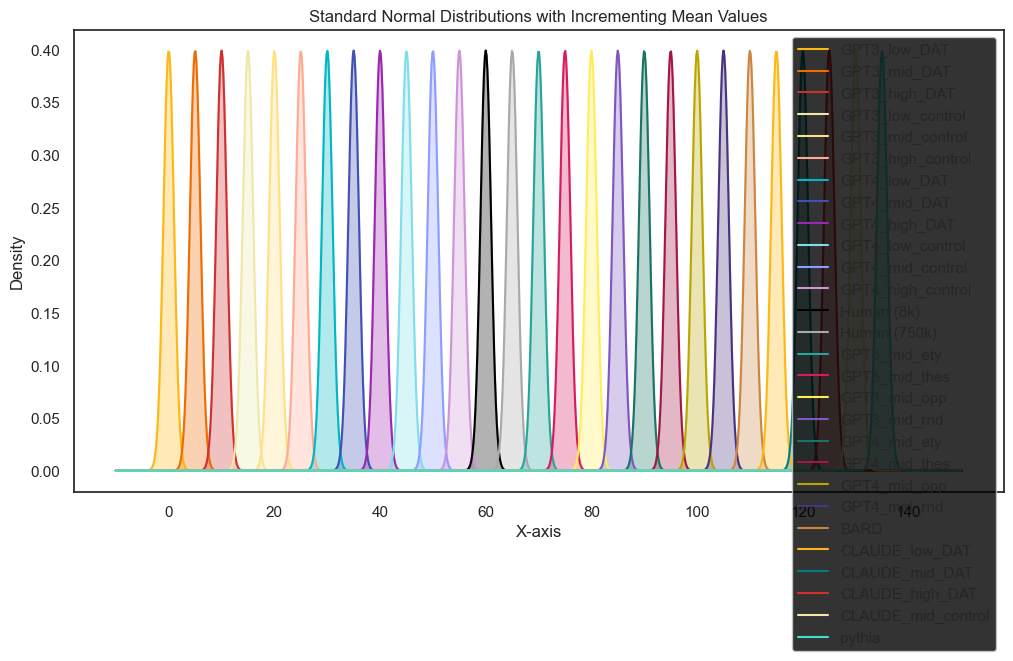

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_distributions(colors, spacing=5):
    x = np.linspace(-10, 10 + len(colors) * spacing, 1000)
    
    plt.figure(figsize=(12, 6))
    
    for i, (key, color) in enumerate(colors.items()):
        mean = i * spacing
        y = norm.pdf(x, loc=mean, scale=1)
        plt.plot(x, y, color=color, label=key)
        plt.fill_between(x, y, color=color, alpha=0.3)
        
    plt.legend()
    plt.xlabel('X-axis')
    plt.ylabel('Density')
    plt.title('Standard Normal Distributions with Incrementing Mean Values')
    plt.show()



plot_distributions(colors)


## Load human data
* Olson and coll. (2021) data - ~8k
* DAT website data harvest - 750k

In [246]:
#load DAT Olson's data
filename = "study2.tsv"

# read the data into a DataFrame
df_human = pd.read_csv(filename, sep='\t')

# extract the "dat" column as a list of floats
dat_study = df_human['dat'].astype(float).tolist()

## 3 Human words

In [179]:
import pandas as pd
import collections

# Load your DataFrame
# df = ...

n_words = 5  # Set the number of most common words to find

# Concatenate all the words from columns 'word.1' to 'word.10'
all_words = df_human.loc[:, 'word.1':'word.10'].values.flatten()

# Count the occurrences of each word
word_counter = collections.Counter(all_words)

# Find the n most common words
most_common_words = word_counter.most_common(n_words)

# Calculate the percentage of occurrences for each of the n most common words
total_words = len(all_words)
most_common_words_percentage = [(word, count / total_words * 1000) for word, count in most_common_words]

# Print the n most common words with their percentages
print(f"Top {n_words} most common words with their percentage of occurrence:")
for word, percentage in most_common_words_percentage:
    print(f"{word}: {percentage:.2f}%")


Top 5 most common words with their percentage of occurrence:
Car: 11.68%
Tree: 9.40%
Dog: 8.38%
car: 8.03%
Book: 6.44%


In [247]:
#load DAT big data file
global_crea = pd.read_csv('./global-creativity.csv')
DAT_bigdata = global_crea['score']

## Fetch machine data
* GPT-3.5turbo
* GPT-4

1. Glob all data files (`.json`).
2. Iterate through samples.
3. Split the tokens and keep only the words.
4. Define strategy used from filename.
5. Define temperature level from filename.
6. Define model from filename
7. Compute DAT score for the given sample of 10 words. (DAT model computes pairwise semantic distances)
8. Store result as a row in a dataframe

In [387]:

import json
import pandas as pd
import fnmatch
import os
import re

import re

def extract_words_with_stars(input_list):
    pattern = r'\*\*(\w+)\*\*'
    words_with_stars = []

    for string in input_list:
        matches = re.findall(pattern, string)
        if matches:
            words_with_stars.extend(matches)

    return words_with_stars

# Define the file path where the data is located
data_path = '../data/'

# Define a dictionary to store the results of model.dat(words)
results_dict = {'Temperature': [], 'Strategy': [], 'Score': [], 'Model': [], 'Control': [], 'Words': []}

# Define a list of patterns to match file names with
file_patterns = ['*sample_*', '*gpt4_*']
bard_data = []
pythia_data = []
# Loop through each file in the data path
for file in sorted(os.listdir(data_path)):
    
    # Check if the file matches any of the specified patterns
    if any(fnmatch.fnmatch(file, pattern) for pattern in file_patterns):
        
        # Open the file and load the JSON data
        with open(os.path.join(data_path, file), 'r') as f:
            data = json.load(f)
        
        # Loop through each key in the JSON data
        for i in data.keys():
            
            # Split the words into a list
            # Split the words into a list
            words = data[i].split()
            if 'bard' in file:
                
                words = extract_words_with_stars(words)
                bard_data.append(words)
            #elif 'pythia' in file:
            #    pythia_data.append(words)
                #print(words)
            else:
                # Find the indices of '1.' to '10.'
                indices = [m.start() for m in re.finditer(r'\b(?:[1-9]|10)\.', data[i])]

                # Extract the words after '1.' to '10.' and store them in a new list
                new_words = []
                for idx in range(len(indices)):
                    if idx < len(indices) - 1:
                        new_words.append(data[i][indices[idx] + 3:indices[idx + 1]].strip())
                    else:
                        new_words.append(data[i][indices[idx] + 3:].strip())

                words = new_words
            
            # Define the strategy based on the file name
            if 'sample_thes' in file or 'gpt4_thes' in file:
                strategy = 'Thesaurus'
            elif 'sample_oppo' in file or 'gpt4_oppo' in file:
                strategy = 'Opposition'
            elif 'sample_ety' in file or 'gpt4_ety' in file:
                strategy = 'Etymology'
            elif 'sample_rand' in file:
                strategy = 'Random'
            elif 'none' in file:
                strategy = 'Original instructions'
            # NOTE: The following line messes every sample for the control group
            elif 'nothing' in file:
                strategy = 'Control'
            
            # Define the condition based on the file name
            if 'temp1.5' in file:
                condition = 'High'
            elif 'temp0.5' in file:
                condition = 'Low'
            elif 'temp1.0' in file:
                condition = 'Mid'
            elif 'temp0.7' in file:
                condition = 'Mid'
            elif 'temp0.2' in file:
                condition = 'Low'
            elif 'temp0.9' in file:
                condition = 'High'
            elif 'temp1.0' and 'pythia' in file:
                condition = 'High'
            elif 'temp1.2' and 'claude' in file:
                condition = 'High'
            else:
                condition = 'Mid'
            
            # Define the model based on the file name
            if 'gpt4' in file:
                llm = 'GPT4'
            elif 'claude' in file:
                llm = 'CLAUDE'
            elif 'bard' in file:
                llm = 'BARD'
            elif 'pythia' in file:
                llm = 'PYTHIA'
            elif 'oasst_stablelm' in file:
                llm = 'Stable_LM_open'
            elif 'stablelm' in file:
                llm = 'Stable_LM_sai'
            else:
                llm = 'GPT3'
            
            # Loop through each word in the list
            score = model_dat.dat(words)
             
            # Append the results to the dictionary
            results_dict['Temperature'].append(condition)
            results_dict['Strategy'].append(strategy)
            results_dict['Score'].append(score)
            results_dict['Words'].append(words)
            results_dict['Model'].append(llm)
            if strategy == 'Control':
                results_dict['Control'].append('Control')
            elif strategy == 'Original instructions':
                results_dict['Control'].append('Original instructions')
            else:
                results_dict['Control'].append('Strategy')

# Convert the results dictionary to a Pandas DataFrame
results_df = pd.DataFrame(results_dict)

Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 9
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 9
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Nu

In [52]:
words = extract_words_with_stars(bard_data[0])
words

['Time',
 'Space',
 'Matter',
 'Energy',
 'Life',
 'Death',
 'Love',
 'Hate',
 'Beauty',
 'Ugliness']

In [106]:
results_df

,Temperature,Strategy,Score,Model,Control,Words
0,Mid,Original instructions,58.088948,BARD,Original instructions,"[Time, Space, Matter, Energy, Life, Death, Lov..."
1,Mid,Original instructions,60.625761,BARD,Original instructions,"[Earth, Air, Fire, Water, Life, Death, Love, H..."
2,Mid,Original instructions,58.659325,BARD,Original instructions,"[Sun, Moon, Star, Planet, Galaxy, Universe, Ti..."
3,Mid,Original instructions,46.572843,BARD,Original instructions,"[Love, Hate, Joy, Sorrow, Anger, Fear, Hope, D..."
4,Mid,Original instructions,49.547435,BARD,Original instructions,"[Life, Death, Dream, Reality, Hope, Fear, Love..."
...,...,...,...,...,...,...
8567,None,Original instructions,81.045845,Human (8k),Original instructions,NaN
8568,None,Original instructions,84.801131,Human (8k),Original instructions,NaN
8569,None,Original instructions,82.258960,Human (8k),Original instructions,NaN
8570,None,Original instructions,82.205565,Human (8k),Original instructions,NaN


## Concatenate all human and machine data 

In [388]:
# Concatenate the website data with the results DataFrame
results_df = pd.concat([results_df, pd.DataFrame({'Temperature': np.tile(None, len(DAT_bigdata)),
                                                  'Strategy': np.tile('Original instructions', len(DAT_bigdata)),
                                                  'Score': np.array(DAT_bigdata),
                                                  'Model': np.tile('Human (750k)', len(DAT_bigdata)),
                                                  'Control': np.tile('Original instructions', len(DAT_bigdata))})])
# concat with study data
results_df = pd.concat([results_df, pd.DataFrame({'Temperature': np.tile(None, len(dat_study)),
                                                  'Strategy': np.tile('Original instructions', len(dat_study)),
                                                  'Score': np.array(dat_study),
                                                  'Model': np.tile('Human (8k)', len(dat_study)),
                                                  'Control': np.tile('Original instructions', len(dat_study))})])


In [183]:
results_df["Model"].unique()

array(['BARD', 'CLAUDE', 'GPT3', 'GPT4', 'Stable_LM', 'PYTHIA',
       'Human (750k)', 'Human (8k)'], dtype=object)

In [ ]:
results_df.to_csv('concatenated_results.csv', index=False)

### Will be used later when anlyzing and plotting data

In [8]:
def normalize_filter(df):
    df['Score'] = (df['Score'] - df['Score'].mean()) / df['Score'].std()
    return df[(df['Score'] >= -3) & (df['Score'] <= 3)]

## Word Counts

In [430]:
def create_bar_plot(word_counts, n_lists=None, ylim=(0, 90), palette_name='Set2', save=False, modelname=' ', temp=' ', strategy=' ', alpha=0.8):
    title = '{} ({} temperature)'.format(modelname, temp)
    title = '{} temperature'.format(temp)
    filename = '{}_word-counts_{}_{}.png'.format(modelname, temp, strategy)
    if n_lists is None:
        n_lists = len(word_counts)/10
    words, counts = zip(*word_counts)
    num_words = len(words)
    
    # Create an array of colors
    colors = plt.get_cmap(palette_name)(np.linspace(0.6, 0.8, num_words))
    
    # Set the bar width to have more space between bars
    bar_width = 0.5
    
    # Create the bar plot
    fig, ax = plt.subplots(figsize=(4, 3))
    bars = ax.bar(words, [(x/n_lists)*100 for x in counts], width=bar_width, color=colors, alpha=alpha)
    
    # Add angle to the bar labels
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        # set horizontal alignment to right
        label.set_ha("right")
    
    # Set plot labels and title
    ax.set_xlabel('Words')
    ax.set_ylabel('Percentage (%)')
    ax.set_title(title, fontsize=16)
    ax.set_ylim(ylim)
    # Adjust the bottom margin to prevent cropping of labels when saving
    plt.subplots_adjust(bottom=0.25)
    
    if save:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    else :
        plt.show()

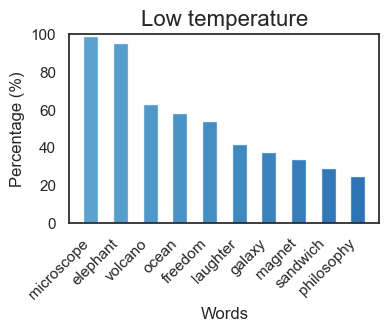

In [431]:
from multiple_test import most_common_words
import collections

modelname = 'GPT4'
temp = 'Low'
strategy = 'Original instructions'
palette = 'Blues'
n_words = 10

df = results_df.loc[(results_df['Model']==modelname) & (results_df['Strategy']==strategy ) &
                    ((results_df['Temperature']==temp))]

# Use explode to create a new row for each word
all_words = [word for word_list in df['Words'] for word in word_list]
all_words = df['Words'].tolist()
n_lists = len(all_words)
all_words = [word for sublist in all_words for word in sublist]

create_bar_plot(most_common_words(all_words, n_words), n_lists=n_lists, ylim=(0, 100), alpha=0.9, palette_name=palette,
                save=True, modelname=modelname, temp=temp, strategy=strategy)

In [143]:
model_word_counts

[[('Car', 11.68), ('Tree', 9.4), ('Dog', 8.38)],
 [],
 [('volcano', 39.348171701112875),
  ('elephant', 60.810810810810814),
  ('microscope', 65.58028616852147)],
 [('ocean', 26.697530864197528),
  ('computer', 27.9320987654321),
  ('elephant', 37.808641975308646)],
 [('ocean', 33.957604445359124),
  ('love', 35.39823008849557),
  ('chair', 42.601358304177815)],
 [('abyss', 5.4045201441205375),
  ('adjective', 8.188666885031116),
  ('adverb', 9.82640026203734)]]

['GPT4', 'GPT3', 'CLAUDE', 'PYTHIA', 'Stable_LM_sai', 'BARD', 'Human']


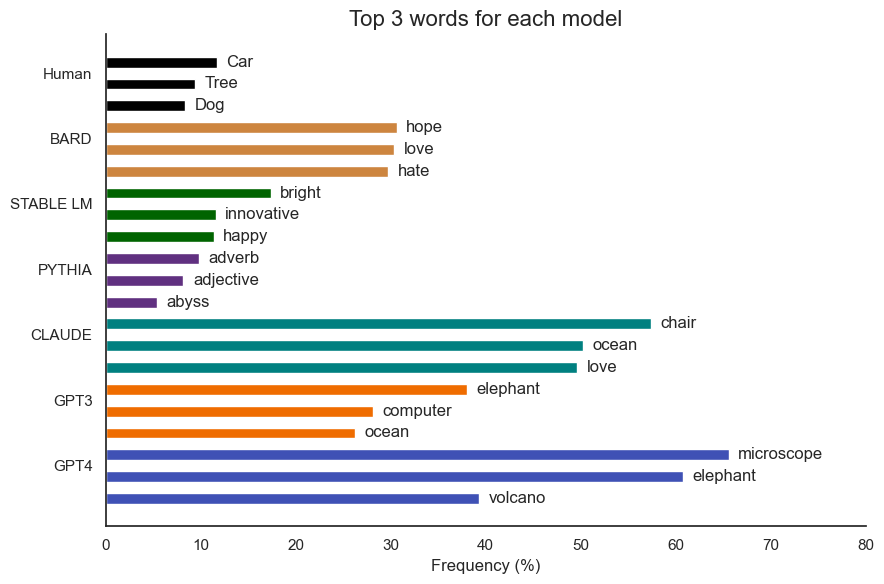

In [423]:
import pandas as pd
import matplotlib.pyplot as plt
from multiple_test import most_common_words
import collections

colors = {
    'GPT4': '#3F51B5',
    'GPT3': '#EF6C00',
    'CLAUDE': 'teal',
    'PYTHIA': '#603080',
    'Stable_LM_sai': 'darkgreen',
    'BARD': 'peru',
    'Human': 'black'
}

# Add the human data
human_data = [("Dog", 8.38), ("Tree", 9.40), ("Car", 11.68)]
model_word_counts = []

# Assuming results_df is already loaded
model_names = list(colors.keys())

n_words = 3

# Iterate over all models and accumulate the word counts
for model_name in model_names[:-1]:  # Exclude the last model_name, "Human"
    temp = 'Mid'
    strategy = 'Original instructions'

    df = results_df.loc[(results_df['Model'] == model_name) & (results_df['Strategy'] == strategy) &
                        (results_df['Temperature'] == temp)]

    all_words = df['Words'].tolist()
    n_lists = len(all_words)
    all_words = [word for sublist in all_words for word in sublist]

    word_counts = most_common_words(all_words, n_words)
    word_counts_percentage = [(word, count / len(all_words) * 10 * 100) for word, count in word_counts]
    model_word_counts.append(sorted(word_counts_percentage, key=lambda x: x[1], reverse=False))

# Add the human data to model_word_counts
model_word_counts.append(human_data)

# Create the horizontal bar plot
fig, ax = plt.subplots(figsize=(9, 6))

bar_width = 0.50
bar_positions = [i for i in range(n_words * len(model_names))]

for i, (model_name, word_counts) in enumerate(zip(model_names, model_word_counts)):
    word_labels, counts = zip(*word_counts)
    for j, (word, count) in enumerate(zip(word_labels, counts)):
        ax.barh(bar_positions[i * n_words + j], count, bar_width, color=colors[model_name])
        ax.text(count + 1, bar_positions[i * n_words + j], word, va='center')
print(model_names)
model_names[4] = 'STABLE LM'
ax.set_yticks([(i * n_words) + n_words / 2 for i in range(len(model_names))])
ax.set_yticklabels(model_names)

ax.set_xlabel('Frequency (%)')
ax.set_title('Top 3 words for each model', fontsize=16)
ax.set_xlim(0, 80)
# remove box frame
ax.spines['top'].set_visible(False)
# remove right frame
ax.spines['right'].set_visible(False)
plt.tight_layout()

# Save the plot
plt.savefig(f"{'_'.join(model_names)}_top{n_words}_words_percentage.png", dpi=300)

# Show the plot
plt.show()


# Overall differences
Every responses

In [67]:
df

,Temperature,Strategy,Score,Model,Control,Words
0,Mid,Original instructions,58.659325,BARD,Original instructions,"[sun, moon, star, planet, galaxy, universe, ti..."
1,Mid,Original instructions,71.116729,BARD,Original instructions,"[air, apple, book, cat, dog, earth, fire, gold..."
2,Mid,Original instructions,59.013012,BARD,Original instructions,"[air, earth, fire, water, time, space, mind, b..."
3,Mid,Original instructions,73.604687,BARD,Original instructions,"[book, chair, dog, fish, house, key, money, pe..."
4,Mid,Original instructions,56.351731,BARD,Original instructions,"[Love, Hate, Friendship, Enmity, Compassion, M..."
...,...,...,...,...,...,...
3254,Mid,Original instructions,56.071326,PYTHIA,Original instructions,"[<|prompter|>Please, enter, 10, words, that, a..."
3255,Mid,Original instructions,56.071326,PYTHIA,Original instructions,"[<|prompter|>Please, enter, 10, words, that, a..."
3256,Mid,Original instructions,56.071326,PYTHIA,Original instructions,"[<|prompter|>Please, enter, 10, words, that, a..."
3257,Mid,Original instructions,56.071326,PYTHIA,Original instructions,"[<|prompter|>Please, enter, 10, words, that, a..."


In [205]:
df.Model.unique()

array(['BARD', 'CLAUDE', 'GPT3', 'GPT4', 'Human (750k)', 'Human (8k)',
       'PYTHIA', 'Stable_LM_open', 'Stable_LM_sai'], dtype=object)

C:\Users\User\AppData\Local\Temp\ipykernel_11308\2714379399.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Model'] = df['Model'].replace('Stable_LM_sai', 'STABLE LM')


IndexError: index 0 is out of bounds for axis 0 with size 0

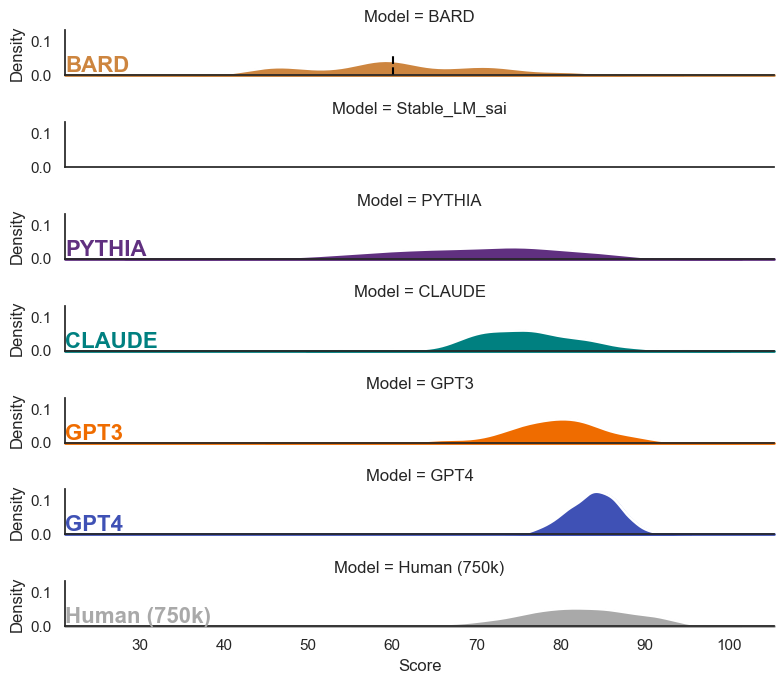

In [429]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
#from multiple_test import *
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# Initialize the FacetGrid object
pal = [colors['GPT3_mid_DAT'],
       colors['GPT4_mid_DAT'],
       colors['CLAUDE_mid_DAT'],
       colors['Stable_LM_sai_mid_DAT'],
       colors['Human (750k)'],
       colors['BARD_mid_DAT'],
       colors['PYTHIA_mid_DAT']]
order = ['BARD', 'Stable_LM_sai', 'PYTHIA', 'CLAUDE', 'GPT3', 'GPT4', 'Human (750k)']
df = results_df.loc[(results_df['Strategy']=='Original instructions') &
                    (results_df['Temperature']=='Mid') | (results_df['Temperature'].isnull())]

# replace model name 'Stable_LM_sai' with 'STABLE LM'
df['Model'] = df['Model'].replace('Stable_LM_sai', 'STABLE LM')

df = df.groupby('Model').apply(lambda x: x[np.abs(x['Score'] - x['Score'].mean()) <= 3 * x['Score'].std()]).reset_index(drop=True)
df = df.groupby('Model').apply(lambda x: x.sample(min(len(x), 500), random_state=32)).reset_index(drop=True)

g = sns.FacetGrid(df, row="Model", hue="Model", aspect=8, height=1, palette=[pal[5], pal[2], pal[0], pal[1], pal[4], pal[3], pal[6]], row_order=order)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Score",
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=1)
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    # check if Human is in the label
    #txt = f"{label} ({len(df.loc[df['Model']==label])})"
    if 'Human' not in label:
        txt = f"{label}"
    else:
        txt = f"{label}"
    ax.text(0, .2, txt, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes,fontsize=16)
g.map(label, "Score")
mean_conf, pvals, tvals = analyze_results(df, 'Model', order)
# Add vertical lines for mean and confidence intervals
for ax, model in zip(g.axes.flat, order):
    if model == 'Human (8k)':
        ax.axvline(mean_conf[mean_conf['Model'] == model]['median'].values[0], color='white', linestyle='--', ymin=0, ymax=0.5)
    else:
        ax.axvline(mean_conf[mean_conf['Model'] == model]['median'].values[0], color='black', linestyle='--', ymin=0, ymax=0.5)
    #ax.axvline(mean_conf[mean_conf['Model'] == model]['ci_low'].values[0], color='gray', linestyle='--', ymin=0, ymax=0.5)
    #ax.axvline(mean_conf[mean_conf['Model'] == model]['ci_high'].values[0], color='gray', linestyle='--', ymin=0, ymax=0.5)
for ax in g.axes.flat:
            ax.set_xlabel('Creativity score', fontsize=16)
            for label in ax.get_xticklabels():
                  label.set_fontsize(14)
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.set(xlim=(30, 100))
g.savefig('DAT_GPT_humans_models_ridge_median_test')
create_heatmap(mean_conf, 'Model', tvals_table=tvals, pvals_table=pvals,
               pal=[pal[5], pal[6], pal[2], pal[0], pal[1], pal[3], pal[4]], order=order, xlim=(50,90), save='DAT_GPT_humans_models_test', large=(13, 6))



In [20]:
len(df['Model'].unique())

5

In [380]:
df

,Temperature,Strategy,Score,Model,Control,Words
0,High,Control,80.653274,GPT3,Control,"[Serendipity, Melancholy, Quintessential, Zeni..."
1,Mid,Control,81.350257,GPT3,Control,"[Serendipity, Mellifluous, Exacerbate, Euphori..."
2,Mid,Control,77.997864,GPT3,Control,"[Jubilant, Flabbergasted, Eclectic, Inconspicu..."
3,Mid,Control,64.982720,GPT3,Control,"[Ostentatious, Inscrutable, Capricious, Mallea..."
4,Mid,Control,75.232829,GPT3,Control,"[Cryptic, Ephemeral, Indolent, Nefarious, Oste..."
...,...,...,...,...,...,...
995,Mid,DAT,78.379820,GPT3,Original instructions,"[Lament, Maverick, Nihilism, Oasis, Panacea, Q..."
996,Mid,DAT,76.631420,GPT3,Original instructions,"[Quail, Rainbow, Spider, Tiger, Umbrella, Viol..."
997,Mid,DAT,81.839615,GPT3,Original instructions,"[Unbridled, Vagary, Wistful, Xenophobia, Yoke,..."
998,Mid,DAT,93.230990,GPT3,Original instructions,"[kangaroo, desktop computer, forest, overture,..."


## GPT-3 vs GPT-4, considering control condition

C:\Users\User\AppData\Local\Temp\ipykernel_11308\2680221866.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Control'] = df['Control'].replace({'Original instructions': 'DAT'})


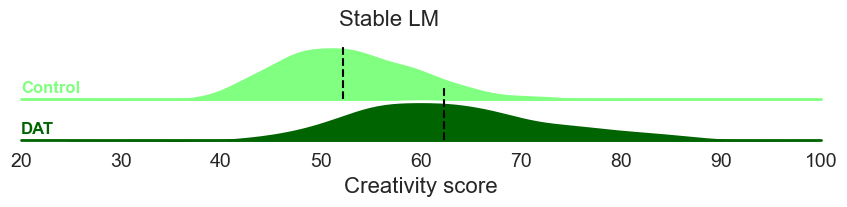

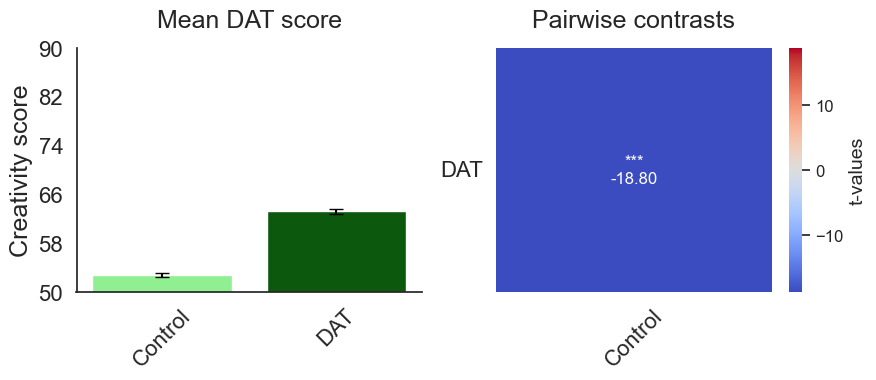

In [406]:
#from multiple_test import *
list_of_dfs = [results_df.loc[(results_df['Model']=='GPT3') &
                              (results_df['Control']!='Strategy')],
               results_df.loc[(results_df['Model']=='GPT4') &
                              (results_df['Temperature']=='Mid') &
                              (results_df['Control']!='Strategy')],
               results_df.loc[(results_df['Model']=='CLAUDE') &
                              (results_df['Temperature']=='Mid') &
                              (results_df['Control']!='Strategy')],
               results_df.loc[(results_df['Model']=='PYTHIA') &
                              (results_df['Temperature']=='Mid') &
                              (results_df['Control']!='Strategy')],
               results_df.loc[(results_df['Model']=='BARD') &
                              (results_df['Temperature']=='Mid') &
                              (results_df['Control']!='Strategy')],]

list_of_dfs = [results_df.loc[(results_df['Model']=='BARD') &
                              (results_df['Temperature']=='Mid') &
                              (results_df['Control']!='Strategy')],]

list_of_dfs = [results_df.loc[(results_df['Model']=='Stable_LM_sai') &
                              (results_df['Temperature']=='Mid') &
                              (results_df['Control']!='Strategy')],]

for e, df in enumerate(list_of_dfs):
      gpt = df["Model"].unique()[0]
      # Remove observations with more or less than 3 std, and then randomly sample up to 500 observations
      df['Control'] = df['Control'].replace({'Original instructions': 'DAT'})
      df = df.groupby('Control').apply(lambda x: x[np.abs(x['Score'] - x['Score'].mean()) <= 3 * x['Score'].std()]).reset_index(drop=True)
      df = df.groupby('Control').apply(lambda x: x.sample(min(len(x), 500), random_state=42)).reset_index(drop=True)
            

      # Initialize the FacetGrid object
      pal = [colors[f'{gpt}_mid_DAT'], colors[f'{gpt}_mid_control']]
      order = ['Control', 'DAT']
      g = sns.FacetGrid(df, row="Control", hue="Control", aspect=9, height=1, palette=[pal[1], pal[0]], row_order=order)

      # Draw the densities in a few steps
      g.map(sns.kdeplot, "Score",
            bw_adjust=1, clip_on=False,
            fill=True, alpha=1, linewidth=1.5)
      g.map(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=1)

      # passing color=None to refline() uses the hue mapping
      g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

      # txt = f"{label} ({len(df.loc[df['Control']==label])})"
      # Define and use a simple function to label the plot in axes coordinates
      def label(x, color, label):
            ax = plt.gca()
            txt = f"{label}"
            ax.text(0, .2, txt, fontweight="bold", color=color,
                        ha="left", va="center", transform=ax.transAxes)
      # change title from the FaceGrid object
      #g.set_titles("Stable LM")
      g.map(label, "Score")
      mean_conf, pvals, tvals = analyze_results(df, 'Control', order=order)
      #print(mean_conf)
      # Add vertical lines for mean and confidence intervals
      for ax, model in zip(g.axes.flat, [0,1]):
            ax.axvline(mean_conf['median'][model], color='black', linestyle='--')
            #ax.axvline(mean_conf['1std'][model], color='gray', linestyle='--')
            #ax.axvline(mean_conf['-1std'][model], color='gray', linestyle='--')
      # Set the subplots to overlap
      for ax in g.axes.flat:
            ax.set_xlabel('Creativity score', fontsize=16)
            for label in ax.get_xticklabels():
                  label.set_fontsize(14)
      g.figure.subplots_adjust(hspace=-.25)

      # Remove axes details that don't play well with overlap
      g.set_titles("")
      # set the main title of the figure
      
      g.set(yticks=[], ylabel="")
      g.despine(bottom=True, left=True)
      g.set(xlim=(20, 100))
      g.fig.suptitle(df['Model'].unique()[0], fontsize=16)
      g.fig.suptitle('Stable LM', fontsize=16)
      g.savefig('DAT_GPT_control4_kde_{}'.format(str(e)), dpi=300)
      create_heatmap(mean_conf, 'Control', tvals_table=tvals, pvals_table=pvals, pal=reversed(pal), order=['Control', 'DAT'], 
                     save='DAT_GPT_control6_{}'.format(str(e)), large=(9, 4), xlim=(50,90), rotation=45, axis_name='Creativity score')

## Injecting strategies

In [348]:
def get_palette(model, order):
    color_map = {
        'GPT3': {
            'Etymology': colors['GPT3_mid_ety'],
            'DAT': colors['GPT3_mid_DAT'],
            'Control': 'gold',
            'Opposition': colors['GPT3_mid_control'],
            'Random': colors['GPT3_mid_rnd'],
            'Thesaurus': colors['GPT3_mid_thes']
        },
        'GPT4': {
            'Etymology': colors['GPT4_mid_ety'],
            'Control': colors['GPT4_mid_DAT'],
            'DAT': colors['GPT4_mid_control'],
            'Opposition': colors['GPT4_mid_opp'],
            'Thesaurus': colors['GPT4_mid_thes']
        }
    }

    return [color_map[model][strategy] for strategy in order]


C:\Users\User\AppData\Local\Temp\ipykernel_11308\2272939698.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Strategy'] = df['Strategy'].replace({'Original instructions': 'DAT'})


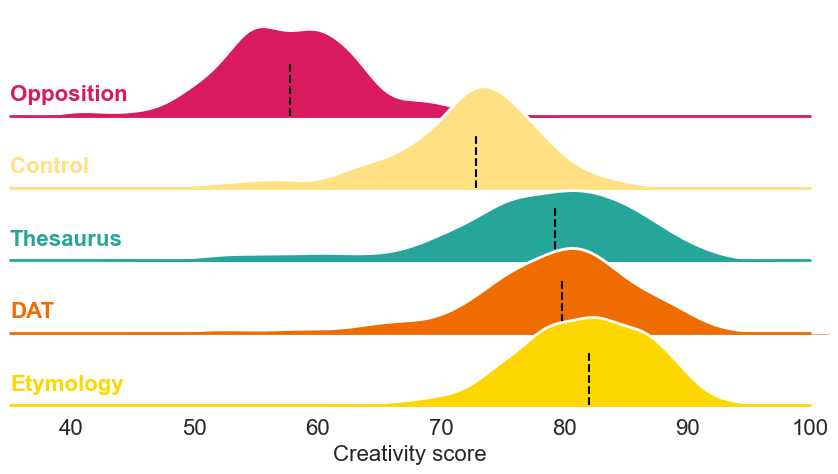

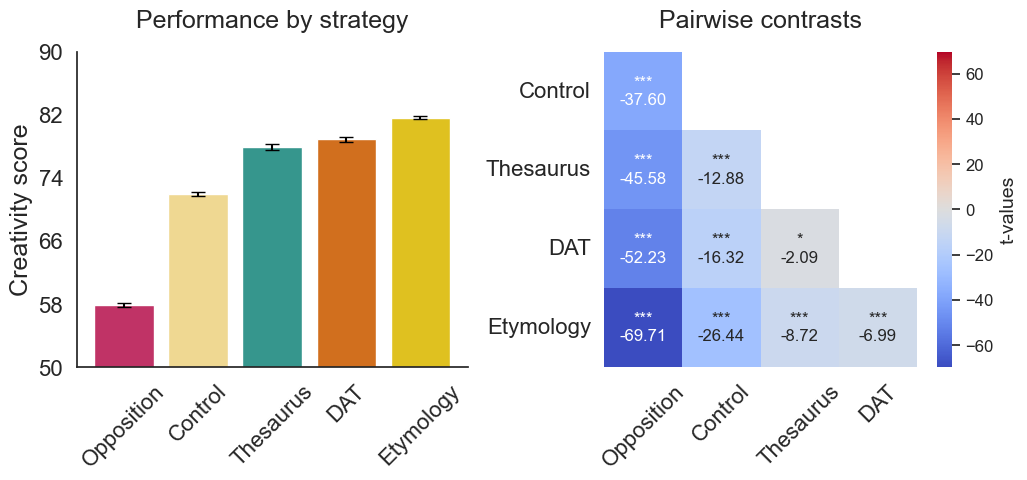

In [370]:
###PLOT STRATEGIES FOR GPT-3

pal = {'GPT3':['black',
               colors['GPT3_mid_DAT'],
               colors['GPT3_mid_control'],
               colors['GPT3_mid_opp'],
               colors['GPT3_mid_thes']],
      'GPT4':[colors['GPT4_mid_ety'],
              colors['GPT4_mid_DAT'],
              colors['GPT4_mid_control'],
              colors['GPT4_mid_opp'],
              colors['GPT4_mid_thes'],]}
gpt = results_df['Model'].unique()[2]
#print(pal[gpt])

df = results_df.loc[(results_df['Model'] == gpt) & (results_df['Temperature'] == 'Mid')]
df['Strategy'] = df['Strategy'].replace({'Original instructions': 'DAT'})
df = df.groupby('Strategy').apply(lambda x: x[np.abs(x['Score'] - x['Score'].mean()) <= 3 * x['Score'].std()]).reset_index(drop=True)
df = df.groupby('Strategy').apply(lambda x: x.sample(min(len(x), 500), random_state=42)).reset_index(drop=True)
df = df[df['Strategy'] != 'Random']

order = df.groupby('Strategy')['Score'].mean().sort_values(ascending=True).index
pal_order = get_palette(gpt, order)
# Initialize the FacetGrid gpt
g = sns.FacetGrid(df,row="Strategy", hue="Strategy", aspect=9,
                  height=1, palette=[pal_order[0], pal_order[3], pal_order[1], pal_order[2],pal_order[4]], row_order=order)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Score",
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=1)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
      ax = plt.gca()
      ax.text(0, .2, f"{label}", fontweight="bold", color=color,
                  ha="left", va="center", transform=ax.transAxes, fontsize=16)
g.map(label, "Score")
# Add vertical lines for mean and confidence intervals
mean_conf, pvals, tvals = analyze_results(df, 'Strategy', order=order)
for ax, model in zip(g.axes.flat, order):
      ax.axvline(mean_conf[mean_conf['Strategy'] == model]['median'].values[0], color='black', linestyle='--', ymin=0, ymax=0.5)
      #ax.axvline(mean_conf[mean_conf['Strategy'] == model]['ci_low'].values[0], color='gray', linestyle='--', ymin=0, ymax=0.5)
      #ax.axvline(mean_conf[mean_conf['Strategy'] == model]['ci_high'].values[0], color='gray', linestyle='--', ymin=0, ymax=0.5)
for ax in g.axes.flat:
    ax.set_xlabel('Creativity score', fontsize=16)
    for label in ax.get_xticklabels():
        label.set_fontsize(16)
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.32)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.set(xlim=(35, 100))
g.despine(bottom=True, left=True)
g.savefig('GPT3_strategy3_kde.png', dpi=300)
'''create_heatmap(mean_conf, 'Strategy', tvals_table=tvals,
            pvals_table=pvals, order=order, pal=pal_order, color_order=[pal_order[2], pal_order[0], pal_order[5], pal_order[3],pal_order[4], pal_order[1]], large=17, xlim=(50, 90),
            save='GPT_strategy2_{}.png'.format(e))'''
create_heatmap(mean_conf, 'Strategy', tvals_table=tvals,
            pvals_table=pvals, order=order, pal=pal_order, color_order=[pal_order[2], pal_order[0], pal_order[4],pal_order[3], pal_order[1]], large=(10.5, 5), xlim=(50, 90),
            save='GPT3_final', rotation=45, title_name='Performance by strategy', axis_name='Creativity score')


In [1]:
def plot_distributions(colors, spacing=5):
    x = np.linspace(-10, 10 + len(colors) * spacing, 1000)
    
    plt.figure(figsize=(12, 6))
    
    for i, color in enumerate(colors):
        mean = i * spacing
        y = norm.pdf(x, loc=mean, scale=1)
        plt.plot(x, y, color=color, label=f'Distribution {i+1}')
        plt.fill_between(x, y, color=color, alpha=0.3)
        
    plt.legend()
    plt.xlabel('X-axis')
    plt.ylabel('Density')
    plt.title('Standard Normal Distributions with Incrementing Mean Values')
    plt.show()

plot_distributions(pal_order)

NameError: name 'pal_order' is not defined

['#1A7466', '#3F51B5', '#8C9EFF', '#BBA600', '#A51645']


C:\Users\User\AppData\Local\Temp\ipykernel_11308\220482640.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Strategy'] = df['Strategy'].replace({'Original instructions': 'DAT', 'Control': 'Control'})


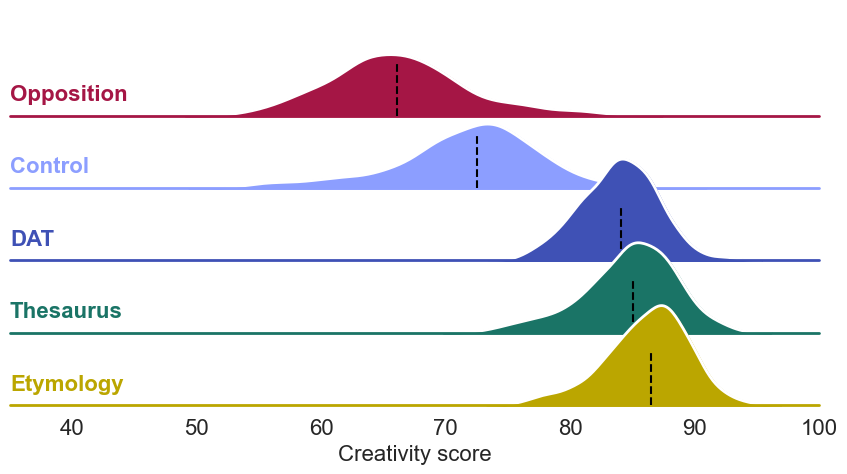

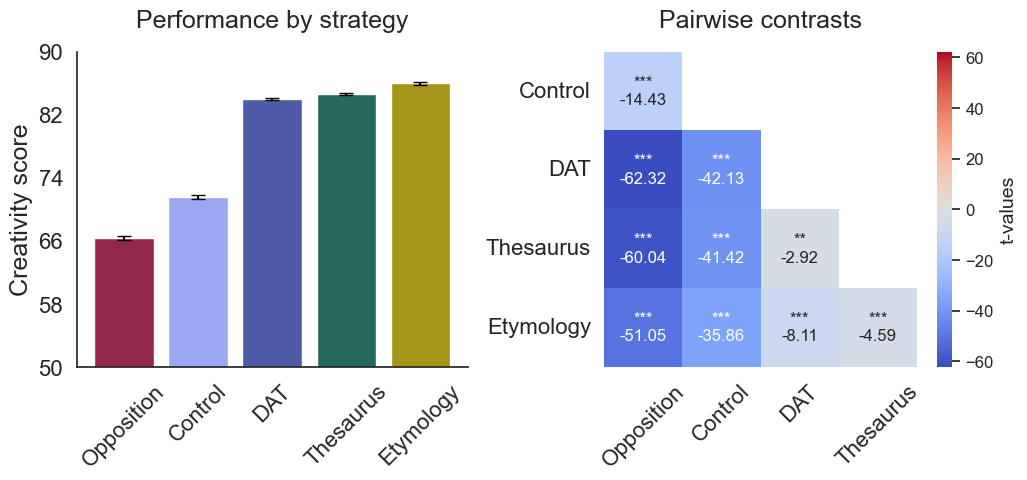

In [371]:
###PLOT STRATEGIES FOR GPT-4

pal = {'GPT3':[colors['GPT3_mid_ety'],
               colors['GPT3_mid_DAT'],
               colors['GPT3_mid_control'],
               colors['GPT3_mid_opp'],
               colors['GPT3_mid_rnd'],
               colors['GPT3_mid_thes']],
      'GPT4':[colors['GPT4_mid_ety'],
              colors['GPT4_mid_DAT'],
              colors['GPT4_mid_control'],
              colors['GPT4_mid_opp'],
              colors['GPT4_mid_thes'],]}
gpt = results_df['Model'].unique()[3]
print(pal[gpt])

df = results_df.loc[(results_df['Model'] == gpt) & (results_df['Temperature'] == 'Mid')]
df['Strategy'] = df['Strategy'].replace({'Original instructions': 'DAT', 'Control': 'Control'})
df_all = df.copy()

#df_all['Strategy'] = df_all['Strategy'].replace({'Original instructions': 'DAT', 'Control': 'Random (Control)'})
df_all = df_all.groupby('Strategy').apply(lambda x: x.sample(min(len(x), 500), random_state=42)).reset_index(drop=True)
df = df.groupby('Strategy').apply(lambda x: x[np.abs(x['Score'] - x['Score'].mean()) <= 3 * x['Score'].std()]).reset_index(drop=True)
df = df.groupby('Strategy').apply(lambda x: x.sample(min(len(x), 500), random_state=42)).reset_index(drop=True)

order = df.groupby('Strategy')['Score'].mean().sort_values(ascending=True).index
pal_order = get_palette(gpt, order)

# Initialize the FacetGrid gpt
g = sns.FacetGrid(df,row="Strategy", hue="Strategy", aspect=9,
                  height=1, palette=[pal_order[2], pal_order[1], pal_order[0], pal_order[3],pal_order[4]], row_order=order,
                  )

'''g = sns.FacetGrid(df,row="Strategy", hue="Strategy", aspect=9,
                  height=1, palette=[pal_order[1], pal_order[0], pal_order[3], pal_order[2],pal_order[4]], row_order=order,
                  )'''

# Draw the densities in a few steps
g.map(sns.kdeplot, "Score",
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=1)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# f"{label} ({len(df.loc[df['Strategy']==label])})"
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
      ax = plt.gca()
      ax.text(0, .2, f"{label}", fontweight="bold", color=color,
                  ha="left", va="center", transform=ax.transAxes, fontsize=16)
g.map(label, "Score")
# Add vertical lines for mean and confidence intervals
mean_conf, pvals, tvals = analyze_results(df_all, 'Strategy', order=order)
for ax, model in zip(g.axes.flat, order):
      ax.axvline(mean_conf[mean_conf['Strategy'] == model]['median'].values[0], color='black', linestyle='--', ymin=0, ymax=0.5)
      #ax.axvline(mean_conf[mean_conf['Strategy'] == model]['ci_low'].values[0], color='gray', linestyle='--', ymin=0, ymax=0.5)
      #ax.axvline(mean_conf[mean_conf['Strategy'] == model]['ci_high'].values[0], color='gray', linestyle='--', ymin=0, ymax=0.5)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.32)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.set(xlim=(35, 100))

for ax in g.axes.flat:
    ax.set_xlabel('Creativity score', fontsize=16)
    for label in ax.get_xticklabels():
        label.set_fontsize(16)

g.despine(bottom=True, left=True)

g.savefig('GPT4_strategy_kde_final_.png', dpi=300)
create_heatmap(mean_conf, 'Strategy', tvals_table=tvals,
            pvals_table=pvals, order=order, pal=pal_order, color_order=[pal_order[3], pal_order[2], pal_order[1],pal_order[4], pal_order[0]], large=(10.5, 5), xlim=(50, 90),
            save='GPT4_strategy_final.png', rotation=45, title_name='Performance by strategy', axis_name='Creativity score')


In [75]:
results_df.loc[(results_df['Model']=='PYTHIA') &
                              (results_df['Control']=='Original instructions')]

,Temperature,Strategy,Score,Model,Control,Words
8664,Low,Original instructions,NaN,PYTHIA,Original instructions,[]
8665,Low,Original instructions,NaN,PYTHIA,Original instructions,[]
8666,Low,Original instructions,NaN,PYTHIA,Original instructions,[]
8667,Low,Original instructions,NaN,PYTHIA,Original instructions,[]
8668,Low,Original instructions,NaN,PYTHIA,Original instructions,[]
...,...,...,...,...,...,...
9250,Mid,Original instructions,59.163784,PYTHIA,Original instructions,"[Recycling, Sustainable, Renewable, Efficient,..."
9251,Mid,Original instructions,73.857110,PYTHIA,Original instructions,"[Abundant, Ample, Avid, Blissful, Celestial, C..."
9252,Mid,Original instructions,82.621167,PYTHIA,Original instructions,"[Sandwich, Compassion, Symphony, Confectionery..."
9253,Mid,Original instructions,78.833155,PYTHIA,Original instructions,"[Antagonist, Broker, Conspiracy, Constitution,..."


## Effect of temperature 

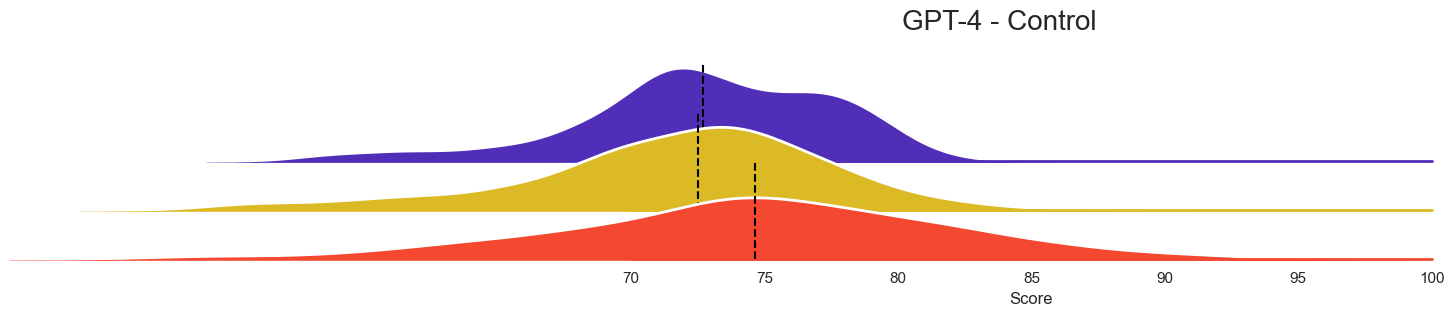

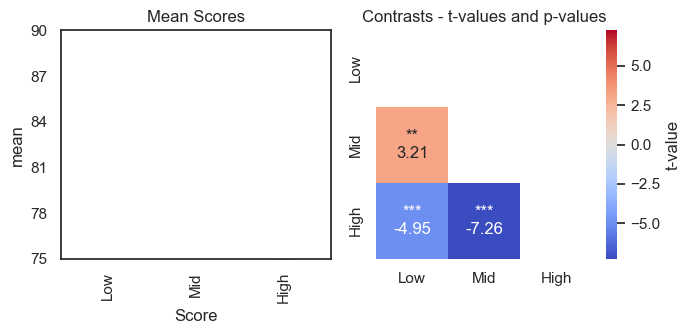

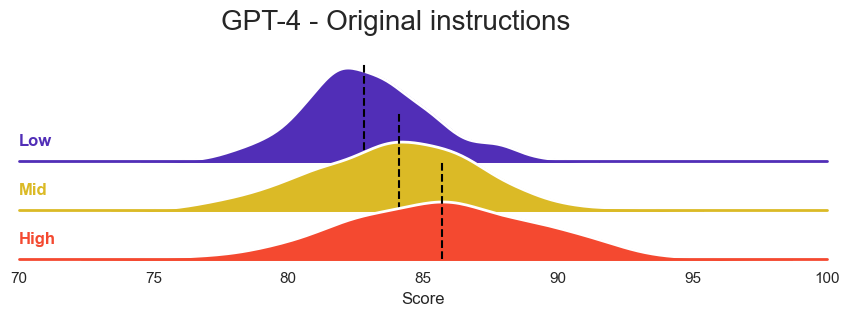

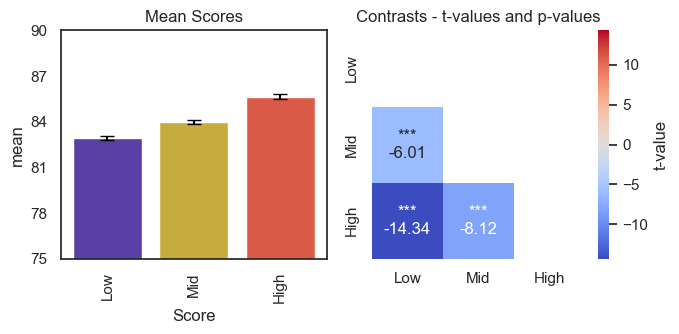

IndexError: index 1 is out of bounds for axis 1 with size 1

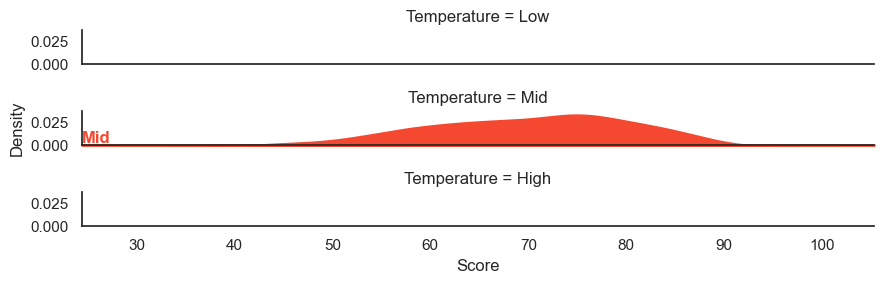

In [218]:
def normalize_filter_std_n(group):
    group_filtered = group[np.abs(group['Score'] - group['Score'].mean()) <= 3 * group['Score'].std()]
    return group_filtered.sample(min(len(group_filtered), 500), random_state=42)


list_of_dfs = [results_df.loc[(results_df['Model']=='GPT4') & 
                              (results_df['Control']=='Control')],
               results_df.loc[(results_df['Model']=='GPT4') &
                              (results_df['Control']=='Original instructions')],
               results_df.loc[(results_df['Model']=='PYTHIA') &
                              (results_df['Control']=='Original instructions')]]
conditions = ['Low', 'Mid', 'High']
list_of_dfs_normalized_filtered = [df.groupby('Temperature', as_index=False).apply(normalize_filter_std_n) for df in list_of_dfs]
for e, df in enumerate(list_of_dfs_normalized_filtered):
      # Initialize the FacetGrid object
      pal = sns.color_palette('CMRmap',n_colors=3, desat=.9)
      # keep color order consistent
      pal = [pal[1], pal[0], pal[2]]
      g = sns.FacetGrid(df, row="Temperature", hue="Temperature", aspect=9, height=1, palette=pal, row_order=conditions)

      # Draw the densities in a few steps
      g.map(sns.kdeplot, "Score",
            bw_adjust=1, clip_on=False,
            fill=True, alpha=1, linewidth=1.5)
      g.map(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=1)

      # passing color=None to refline() uses the hue mapping
      g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

      # f"{label} ({len(df.loc[df['Temperature']==label])})"
      # Define and use a simple function to label the plot in axes coordinates
      def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, f"{label}",
                    fontweight="bold", color=color,ha="left", va="center",
                    transform=ax.transAxes)
      g.map(label, "Score")
       # Add vertical lines for mean and confidence intervals
      mean_conf, pvals, tvals = analyze_results(df, 'Temperature', order=conditions)
      for ax, model in zip(g.axes.flat, ['Low', 'Mid', 'High']):
            ax.axvline(mean_conf[mean_conf['Temperature'] == model]['median'].values[0], color='black', linestyle='--')
            #ax.axvline(mean_conf[mean_conf['Temperature'] == model]['ci_low'].values[0], color='gray', linestyle='--')
            #ax.axvline(mean_conf[mean_conf['Temperature'] == model]['ci_high'].values[0], color='gray', linestyle='--')
      # Set the subplots to overlap
      g.figure.subplots_adjust(hspace=-.5)

      # Remove axes details that don't play well with overlap
      g.set_titles("")
      g.set(yticks=[], ylabel="")
      g.despine(bottom=True, left=True)
      g.set(xlim=(70, 100))
      
      # Set a title for the figure
      g.fig.suptitle(f"GPT-4 - {df['Control'].unique()[0]}", fontsize=20, y=1.05)
      g.savefig('GPT_DAT_temperature2_kde{}.png'.format(e), dpi=300)
      create_heatmap(mean_conf, 'Temperature', tvals_table=tvals, pvals_table=pvals, pal=[pal[1], pal[2], pal[0]], order=['Low', 'Mid', 'High'],
                     save='GPT_DAT_temperature3_{}.png'.format(e), large=(7, 3.5), xlim=(75, 90))

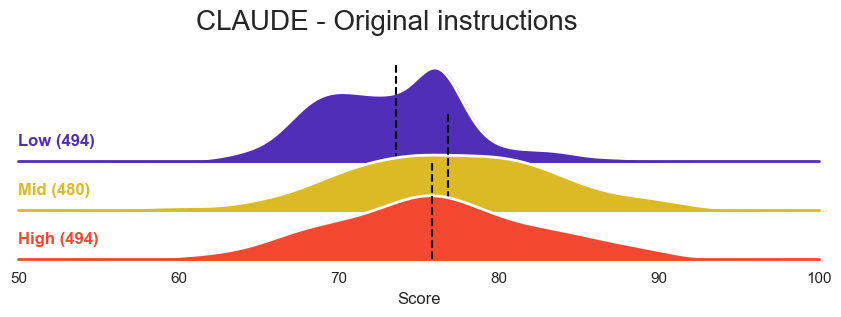

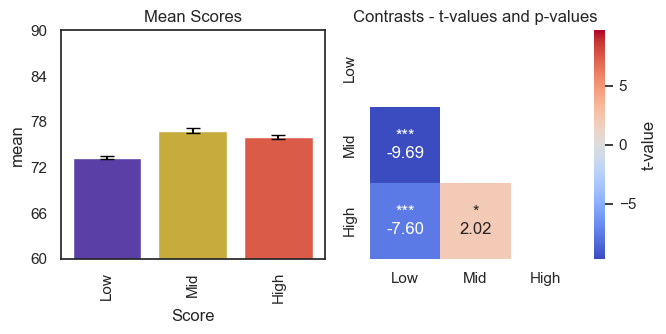

In [242]:
def normalize_filter_std_n(group):
    group_filtered = group[np.abs(group['Score'] - group['Score'].mean()) <= 3 * group['Score'].std()]
    return group_filtered.sample(min(len(group_filtered), 500), random_state=42)


list_of_dfs = [
               results_df.loc[(results_df['Model']=='CLAUDE') &
                              (results_df['Control']=='Original instructions')]]
conditions = ['Low', 'Mid', 'High']
list_of_dfs_normalized_filtered = [df.groupby('Temperature', as_index=False).apply(normalize_filter_std_n) for df in list_of_dfs]
for e, df in enumerate(list_of_dfs_normalized_filtered):
      # Initialize the FacetGrid object
      pal = sns.color_palette('CMRmap',n_colors=3, desat=.9)
      # keep color order consistent
      pal = [pal[1], pal[0], pal[2]]
      g = sns.FacetGrid(df, row="Temperature", hue="Temperature", aspect=9, height=1, palette=pal, row_order=conditions)

      # Draw the densities in a few steps
      g.map(sns.kdeplot, "Score",
            bw_adjust=1, clip_on=False,
            fill=True, alpha=1, linewidth=1.5)
      g.map(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=1)

      # passing color=None to refline() uses the hue mapping
      g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


      # Define and use a simple function to label the plot in axes coordinates
      def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, f"{label} ({len(df.loc[df['Temperature']==label])})",
                    fontweight="bold", color=color,ha="left", va="center",
                    transform=ax.transAxes)
      g.map(label, "Score")
       # Add vertical lines for mean and confidence intervals
      mean_conf, pvals, tvals = analyze_results(df, 'Temperature', order=conditions)
      for ax, model in zip(g.axes.flat, ['Low', 'Mid', 'High']):
            ax.axvline(mean_conf[mean_conf['Temperature'] == model]['median'].values[0], color='black', linestyle='--')
            #ax.axvline(mean_conf[mean_conf['Temperature'] == model]['1std'].values[0], color='gray', linestyle='--')
            #ax.axvline(mean_conf[mean_conf['Temperature'] == model]['-1std'].values[0], color='gray', linestyle='--')
      # Set the subplots to overlap
      g.figure.subplots_adjust(hspace=-.5)

      # Remove axes details that don't play well with overlap
      g.set_titles("")
      g.set(yticks=[], ylabel="")
      g.despine(bottom=True, left=True)
      g.set(xlim=(50, 100))
      
      # Set a title for the figure
      g.fig.suptitle(f"CLAUDE - {df['Control'].unique()[0]}", fontsize=20, y=1.05)
      g.savefig('CLAUDE_DAT_temperature2_kde{}.png'.format(e), dpi=300)
      create_heatmap(mean_conf, 'Temperature', tvals_table=tvals, pvals_table=pvals, pal=[pal[1], pal[2], pal[0]],
                     order=['Low', 'Mid', 'High'], save='CLAUDE_DAT_temperature3_{}.png'.format(e), large=(7, 3.5))

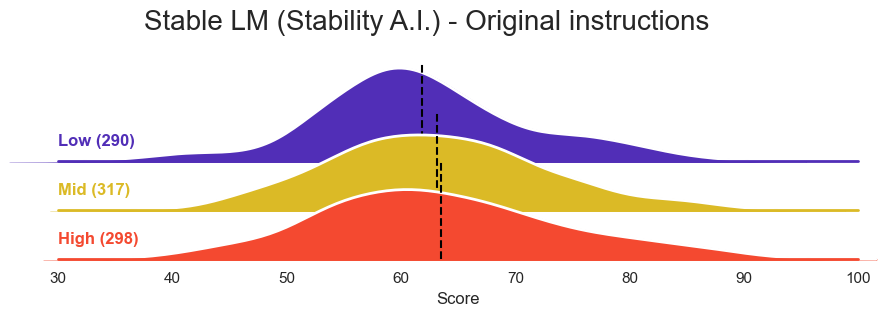

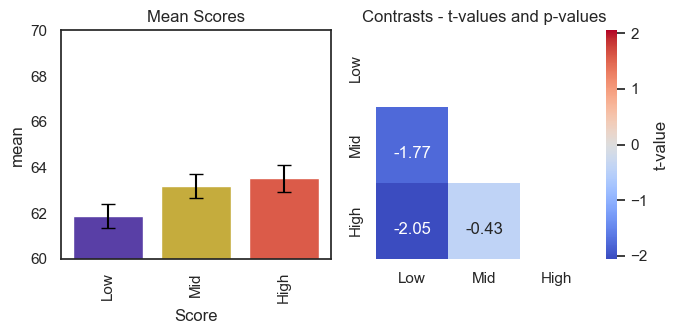

In [216]:
def normalize_filter_std_n(group):
    group_filtered = group[np.abs(group['Score'] - group['Score'].mean()) <= 3 * group['Score'].std()]
    return group_filtered.sample(min(len(group_filtered), 500), random_state=42)


list_of_dfs = [
               results_df.loc[(results_df['Model']=='Stable_LM_sai') &
                              (results_df['Control']=='Original instructions')]]
conditions = ['Low', 'Mid', 'High']
list_of_dfs_normalized_filtered = [df.groupby('Temperature', as_index=False).apply(normalize_filter_std_n) for df in list_of_dfs]
for e, df in enumerate(list_of_dfs_normalized_filtered):
      # Initialize the FacetGrid object
      pal = sns.color_palette('CMRmap',n_colors=3, desat=.9)
      # keep color order consistent
      pal = [pal[1], pal[0], pal[2]]
      g = sns.FacetGrid(df, row="Temperature", hue="Temperature", aspect=9, height=1, palette=pal, row_order=conditions)

      # Draw the densities in a few steps
      g.map(sns.kdeplot, "Score",
            bw_adjust=1, clip_on=False,
            fill=True, alpha=1, linewidth=1.5)
      g.map(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=1)

      # passing color=None to refline() uses the hue mapping
      g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


      # Define and use a simple function to label the plot in axes coordinates
      def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, f"{label} ({len(df.loc[df['Temperature']==label])})",
                    fontweight="bold", color=color,ha="left", va="center",
                    transform=ax.transAxes)
      g.map(label, "Score")
       # Add vertical lines for mean and confidence intervals
      mean_conf, pvals, tvals = analyze_results(df, 'Temperature', order=conditions)
      for ax, model in zip(g.axes.flat, ['Low', 'Mid', 'High']):
            ax.axvline(mean_conf[mean_conf['Temperature'] == model]['mean'].values[0], color='black', linestyle='--')
            #ax.axvline(mean_conf[mean_conf['Temperature'] == model]['1std'].values[0], color='gray', linestyle='--')
            #ax.axvline(mean_conf[mean_conf['Temperature'] == model]['-1std'].values[0], color='gray', linestyle='--')
      # Set the subplots to overlap
      g.figure.subplots_adjust(hspace=-.5)

      # Remove axes details that don't play well with overlap
      g.set_titles("")
      g.set(yticks=[], ylabel="")
      g.despine(bottom=True, left=True)
      g.set(xlim=(30, 100))
      
      # Set a title for the figure
      g.fig.suptitle(f"Stable LM (Stability A.I.) - {df['Control'].unique()[0]}", fontsize=20, y=1.05)
      g.savefig('SLM_sai_temperature2_kde{}.png'.format(e), dpi=300)
      create_heatmap(mean_conf, 'Temperature', tvals_table=tvals, pvals_table=pvals, pal=[pal[1], pal[2], pal[0]],
                     order=['Low', 'Mid', 'High'], save='SLM_sai_DAT_temperature2_{}.png'.format(e), large=(7, 3.5), xlim=(60, 70))

In [ ]:
# count values in each condition
for col in ['Model', 'Control', 'Strategy', 'Temperature']:
      for key in results_df[col].unique():
            print(f'Count values for {col}, {key}:\n'
                  f'{len(results_df.loc[results_df[col]==key])}')